In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import pickle
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import KBinsDiscretizer
import pickle
import optuna

In [2]:
driver_df = pd.read_csv('data/telematics.csv')
driver_df = driver_df.drop(columns = ['Territory'])
categorical_features = ['Insured.sex','Marital','Car.use','Region']

# Create the encoder object
encoder = OneHotEncoder(drop='first', handle_unknown='ignore',sparse_output=False)

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(driver_df[categorical_features])

# Get feature names after encoding
feature_names = encoder.get_feature_names_out(categorical_features)

# Convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=feature_names, index=driver_df.index)

# Drop original categorical columns and concatenate encoded columns
numerical_features = [col for col in driver_df.columns if col not in categorical_features]
driver_df = pd.concat([driver_df[numerical_features], encoded_df], axis=1)

In [44]:
len(driver_df.columns)

53

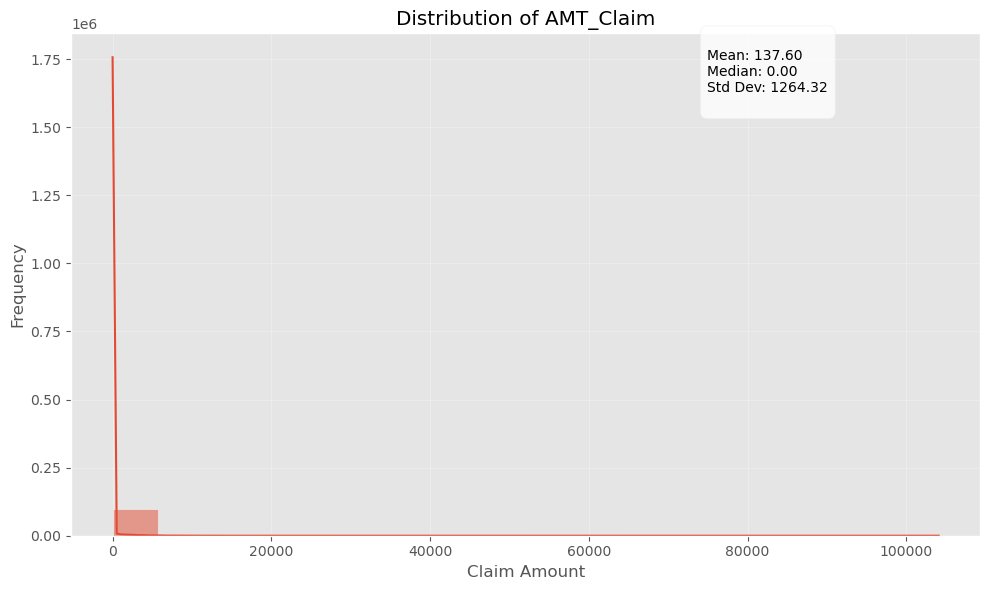

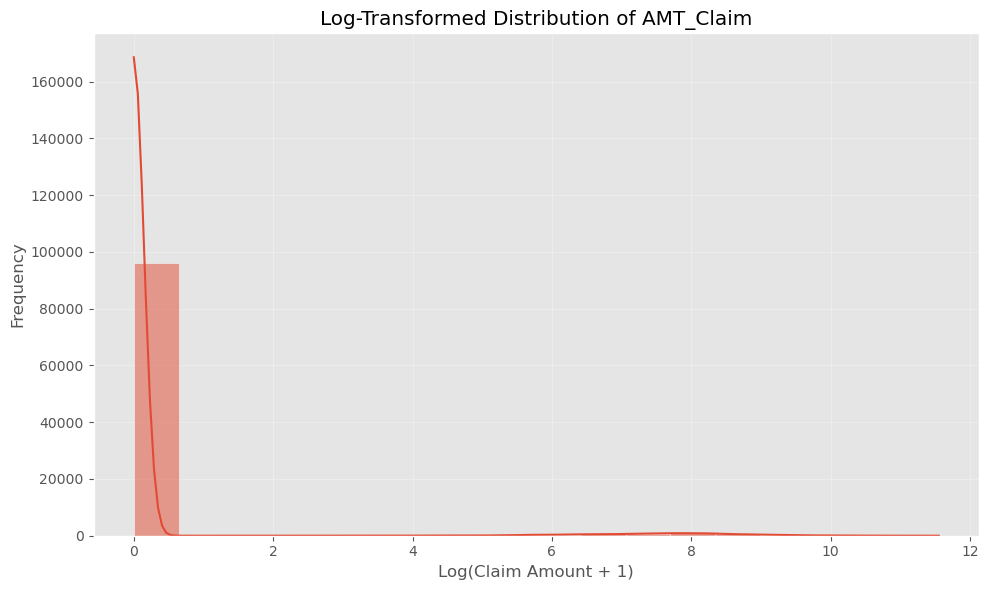

In [45]:
plt.style.use('ggplot')

# Create a simple histogram
plt.figure(figsize=(10, 6))
sns.histplot(driver_df['AMT_Claim'], kde=True)
plt.title('Distribution of AMT_Claim')
plt.xlabel('Claim Amount')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Add statistics annotation
stats_text = f"""
Mean: {driver_df['AMT_Claim'].mean():.2f}
Median: {driver_df['AMT_Claim'].median():.2f}
Std Dev: {driver_df['AMT_Claim'].std():.2f}
"""
plt.annotate(stats_text, xy=(0.7, 0.85), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

# Optional: Log-transformed view if the distribution is highly skewed
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(driver_df['AMT_Claim']), kde=True)
plt.title('Log-Transformed Distribution of AMT_Claim')
plt.xlabel('Log(Claim Amount + 1)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [3]:
driver_df_1 = driver_df.copy()

# Method 2: Using map with lambda
driver_df_1['NB_Claim'] = driver_df_1['NB_Claim'].map(lambda x: 1 if x > 0 else 0)

driver_df_1_train = driver_df_1

In [4]:
driver_df_amt = driver_df_1_train.copy()
#driver_df_amt = driver_df_amt.drop("NB_Claim", axis=1)

X = driver_df_amt.drop('AMT_Claim', axis=1)
#X = driver_df_1_train
y = driver_df_amt['AMT_Claim']
n_bins = 10  # Adjust based on your data distribution
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
y_binned = discretizer.fit_transform(np.array(y).reshape(-1, 1)).astype(int).flatten()
X_train, X_test, y_train, y_test, y_binned_train, y_binned_test = train_test_split(
    X, y, y_binned, 
    test_size=0.15,  # 80-20 split
    random_state=42, 
    stratify=y_binned  # This ensures the bins are distributed similarly
)
X_train, X_val, y_train, y_val, y_binned_train_2, y_binned_test_2 = train_test_split(X_train, y_train, y_binned_train, test_size=0.18, random_state=42, stratify=y_binned_train)

/Users/qinyanghe/opt/anaconda3/envs/MLenvironment/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [81]:
def objective(trial):
    # Define the hyperparameter search space for regression
    param = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 42,
    'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),  # Lower range
    'max_depth': trial.suggest_int('max_depth', 2, 6),  # Lower max depth
    'n_estimators': trial.suggest_int('n_estimators', 100, 3000),  # Allow more estimators
    'min_child_weight': trial.suggest_int('min_child_weight', 3, 10),  # Higher minimum
    'subsample': trial.suggest_float('subsample', 0.5, 0.8),  # Lower subsample
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),  # Lower column sampling
    'gamma': trial.suggest_float('gamma', 0.1, 10),  # Higher gamma range
    'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),  # Much stronger L1 regularization
    'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0),  # Much stronger L2 regularization
    'early_stopping_rounds': 50,  # More patience
}
    
    # Create regressor with current hyperparameters
    model = xgb.XGBRegressor(**param)
    
    # Train with early stopping
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Get predictions on validation set
    y_pred = model.predict(X_val)
    
    # Calculate RMSE (lower is better, but Optuna maximizes by default)
    # So we return the negative RMSE
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    # Alternatively, you can return R² (higher is better)
    # r2 = r2_score(y_val, y_pred)
    # return r2
    
    return -rmse  # Negative RMSE because Optuna maximizes by default

# Create and run Optuna study
study = optuna.create_study(direction='maximize')  # Maximizing negative RMSE (minimizing RMSE)
study.optimize(objective, n_trials=50)  # Adjust n_trials as needed

# Print best results
print('Best trial:')
print('  Value (Negative RMSE):', study.best_trial.value)
print('  RMSE:', -study.best_trial.value)  # Convert back to actual RMSE
print('  Params:')
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')


[I 2025-02-25 01:46:13,763] A new study created in memory with name: no-name-5c99e0ef-8626-4202-b479-da1a94305299
/Users/qinyanghe/opt/anaconda3/envs/MLenvironment/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-25 01:46:21,715] Trial 0 finished with value: -1026.5137496541931 and parameters: {'learning_rate': 0.022498228808097466, 'max_depth': 6, 'n_estimators': 1328, 'min_child_weight': 9, 'subsample': 0.6012379281736537, 'colsample_bytree': 0.7420877886043856, 'gamma': 7.170738678662144, 'reg_alpha': 5.733056442191673, 'reg_lambda': 3.790115369741653}. Best is trial 0 with value: -1026.5137496541931.
/Users/qinyanghe/opt/anaconda3/envs/MLenvironment/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will

KeyboardInterrupt: 

In [58]:
# Train final model with best parameters
best_params = study.best_trial.params
best_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 42,
    #'n_estimators': 50
})

final_model = xgb.XGBRegressor(**best_params)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)

# Evaluate final model
train_pred = final_model.predict(X_train)
val_pred = final_model.predict(X_val)
test_pred = final_model.predict(X_test)

print("\nFinal Model Evaluation:")
print("Train RMSE:", mean_squared_error(y_train, train_pred, squared=False))
print("Validation RMSE:", mean_squared_error(y_val, val_pred, squared=False))
print("Test RMSE:", mean_squared_error(y_test, test_pred, squared=False))
print("Test R²:", r2_score(y_test, test_pred))
print("Test MAE:", mean_absolute_error(y_test, test_pred))

[0]	validation_0-rmse:1278.55901	validation_1-rmse:1163.45618
[1]	validation_0-rmse:1254.47530	validation_1-rmse:1137.90606
[2]	validation_0-rmse:1232.94332	validation_1-rmse:1118.83177
[3]	validation_0-rmse:1211.70496	validation_1-rmse:1100.64192
[4]	validation_0-rmse:1191.86017	validation_1-rmse:1081.77553
[5]	validation_0-rmse:1171.82863	validation_1-rmse:1065.04345
[6]	validation_0-rmse:1165.97983	validation_1-rmse:1060.31090
[7]	validation_0-rmse:1147.36669	validation_1-rmse:1043.24596
[8]	validation_0-rmse:1131.02477	validation_1-rmse:1027.98312
[9]	validation_0-rmse:1115.32269	validation_1-rmse:1015.52732
[10]	validation_0-rmse:1100.72924	validation_1-rmse:1004.81630
[11]	validation_0-rmse:1087.78577	validation_1-rmse:992.42831
[12]	validation_0-rmse:1076.18133	validation_1-rmse:981.92942
[13]	validation_0-rmse:1064.28352	validation_1-rmse:969.40629
[14]	validation_0-rmse:1061.20405	validation_1-rmse:968.02745
[15]	validation_0-rmse:1049.61616	validation_1-rmse:956.63791
[16]	va

/Users/qinyanghe/opt/anaconda3/envs/MLenvironment/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/qinyanghe/opt/anaconda3/envs/MLenvironment/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/qinyanghe/opt/anaconda3/envs/MLenvironment/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [73]:
sum(y_test > 30000)

4

Training RMSE: 43.6374
Test RMSE: 633.7328
Test R²: 0.6891
Test MAE: 107.8562


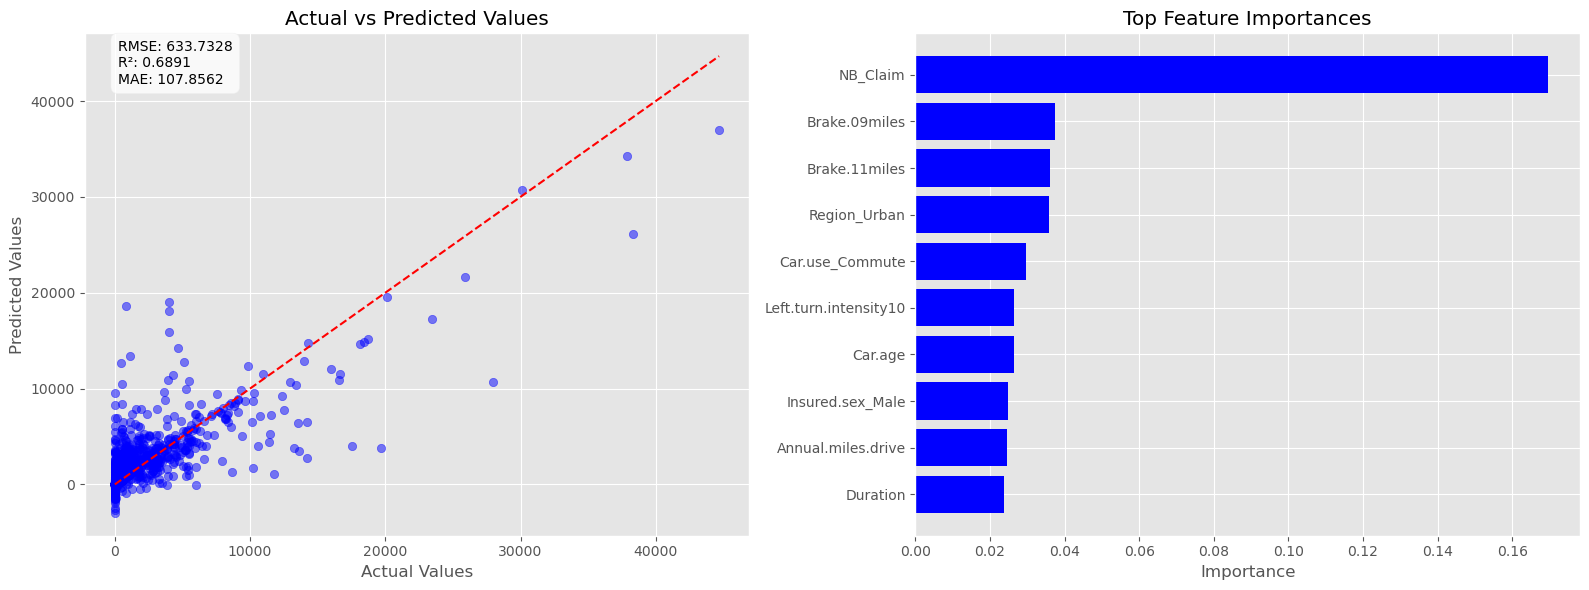

In [77]:
visualize_regression_results(final_model, X_train, y_train, X_test, y_test, feature_names=X_train.columns)

In [70]:
import pickle

# Save the model
with open('models/xgb_amt_068.pkl', 'wb') as file:
    pickle.dump(final_model, file)

In [26]:
import lightgbm as lgb
def visualize_regression_results(model, X_train, y_train, X_test, y_test, feature_names=None):
    """
    Visualize regression model results with two key plots:
    1. Actual vs Predicted Values
    2. Feature Importance (sorted from high to low, top to bottom)
    
    Parameters:
    -----------
    model : trained regression model
        The trained regression model
    X_train : array-like
        Training features
    y_train : array-like
        Training target values
    X_test : array-like
        Test features
    y_test : array-like
        Test target values
    feature_names : list, optional
        Names of features for feature importance plot
    """
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Print metrics
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    
    # Set up the figure layout with 1 row and 2 columns
    plt.figure(figsize=(16, 6))
    
    # 1. Actual vs Predicted Plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    
    test_rmse = 568.7328
    test_r2 = 0.7141
    test_mae = 93.3214
    # Add metrics annotation
    plt.annotate(f'RMSE: {test_rmse:.4f}\nR²: {test_r2:.4f}\nMAE: {test_mae:.4f}',
                xy=(0.05, 0.9), xycoords='axes fraction',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    
    # 2. Feature Importance Plot
    plt.subplot(1, 2, 2)
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Check if feature_names is provided and has the correct length
        if feature_names is not None and len(feature_names) == len(importances):
            features = [feature_names[i] for i in indices]
        else:
            # Fall back to feature indices if names aren't properly provided
            features = [f'Feature {i}' for i in indices]
        
        # Plot top 10 features
        top_n = min(10, len(importances))
        
        # Reverse the order for plotting from top to bottom (highest at top)
        plot_positions = range(top_n-1, -1, -1)
        plot_features = [features[i] for i in range(top_n)]
        plot_importances = importances[indices[:top_n]]
        
        # Plot the bars from high to low (top to bottom) in blue color
        plt.barh(plot_positions, plot_importances, align='center', color='blue')
        
        # Explicitly assign feature names to the y-axis ticks
        plt.yticks(plot_positions, plot_features)
        
        plt.xlabel('Importance')
        plt.title('Top Feature Importances')
    else:
        plt.text(0.5, 0.5, 'Feature importance not available', 
                horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.show()

In [28]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def visualize_regression_results(model, X_train, y_train, X_test, y_test, feature_names=None):
    """
    Visualize regression model results with two separate plots:
    1. Actual vs. Predicted Values
    2. Feature Importance (sorted from high to low, top to bottom)
    
    Parameters:
    -----------
    model : trained regression model
        The trained regression model
    X_train : array-like
        Training features
    y_train : array-like
        Training target values
    X_test : array-like
        Test features
    y_test : array-like
        Test target values
    feature_names : list, optional
        Names of features for feature importance plot
    """
    
    # 1. Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 2. Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # 3. Print metrics
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    
    test_rmse = 568.7328
    test_r2 = 0.7141
    test_mae = 93.3214
    # 4. Plot 1: Actual vs. Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')

    # Annotate metrics on the plot
    plt.annotate(
        f'RMSE: {test_rmse:.4f}\nR²: {test_r2:.4f}\nMAE: {test_mae:.4f}',
        xy=(0.05, 0.9), xycoords='axes fraction',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
    )

    plt.tight_layout()
    plt.show()
    
    # 5. Plot 2: Feature Importance
    plt.figure(figsize=(8, 6))
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Check if feature_names is provided and has the correct length
        if feature_names is not None and len(feature_names) == len(importances):
            features = [feature_names[i] for i in indices]
        else:
            # Fall back to feature indices if names aren't properly provided
            features = [f'Feature {i}' for i in indices]
        
        # Plot top 10 features
        top_n = min(10, len(importances))
        
        # Reverse the order for plotting from top to bottom (highest at top)
        plot_positions = range(top_n-1, -1, -1)
        plot_features = [features[i] for i in range(top_n)]
        plot_importances = importances[indices[:top_n]]
        
        plt.barh(plot_positions, plot_importances, align='center', color='blue')
        plt.yticks(plot_positions, plot_features)
        plt.xlabel('Importance')
        plt.title('Top Feature Importances')
    else:
        # If the model doesn't have feature_importances_
        plt.text(
            0.5, 0.5, 
            'Feature importance not available',
            horizontalalignment='center',
            verticalalignment='center'
        )
    
    plt.tight_layout()
    plt.show()

In [13]:
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def objective(trial):
    # Define the hyperparameter search space for LightGBM regression with adjusted ranges
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),  # smaller learning rate can help generalize
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),  # starting a bit higher
        'num_leaves': trial.suggest_int('num_leaves', 10, 60),  # narrower range to control complexity
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),  # higher minimum samples
        'subsample': trial.suggest_float('subsample', 0.6, 0.8),  # ensure some randomness
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.8),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.1, 5),  # smaller range
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 5.0),  # increased regularization range
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 5.0),  # increased regularization range
        'early_stopping_rounds': 100,
        'verbosity': -1
    }
    
    # Create LightGBM regressor with current hyperparameters
    model = lgb.LGBMRegressor(**param)
    
    # Train with early stopping to prevent overfitting
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',  
    )
    
    # Get predictions on validation set
    y_pred = model.predict(X_val)
    
    # Calculate RMSE (we return negative RMSE because Optuna maximizes by default)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return -rmse

# Create and run Optuna study
study = optuna.create_study(direction='maximize')  # Maximizing negative RMSE (minimizing RMSE)
study.optimize(objective, n_trials=50)  # Adjust n_trials as needed

# Print best results
print('Best trial:')
print('  Value (Negative RMSE):', study.best_trial.value)
print('  RMSE:', -study.best_trial.value)
print('  Params:')
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

# Get best model parameters and update with fixed parameters


[I 2025-02-25 02:19:56,657] A new study created in memory with name: no-name-450bc6fb-5731-488d-bcc9-cee89eb01a38
/Users/qinyanghe/opt/anaconda3/envs/MLenvironment/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-25 02:19:58,267] Trial 0 finished with value: -918.5330208782143 and parameters: {'learning_rate': 0.008670266401935585, 'max_depth': 4, 'n_estimators': 558, 'num_leaves': 17, 'min_child_samples': 81, 'subsample': 0.7578822171246835, 'colsample_bytree': 0.736273415435498, 'min_split_gain': 4.200752522372998, 'reg_alpha': 3.393335109199902, 'reg_lambda': 4.445736555946586}. Best is trial 0 with value: -918.5330208782143.
/Users/qinyanghe/opt/anaconda3/envs/MLenvironment/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecate

Best trial:
  Value (Negative RMSE): -809.0863477244329
  RMSE: 809.0863477244329
  Params:
    learning_rate: 0.03936283768551934
    max_depth: 6
    n_estimators: 2849
    num_leaves: 42
    min_child_samples: 24
    subsample: 0.7470508679060127
    colsample_bytree: 0.6288113290193096
    min_split_gain: 1.1293246813266824
    reg_alpha: 2.956035416720387
    reg_lambda: 4.308460869081199


TypeError: LGBMRegressor.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [15]:
best_params = study.best_trial.params.copy()
best_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': 42,
    'verbosity': -1
})
best_model = lgb.LGBMRegressor(**best_params)

# Train on the full training set with early stopping on a validation set
best_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
)

# Make predictions on test set
y_pred = best_model.predict(X_test)

# Calculate final metrics
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
test_r2 = r2_score(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print(f"Final Model Evaluation:")
print(f"Test RMSE: {test_rmse}")
print(f"Test R²: {test_r2}")
print(f"Test MAE: {test_mae}")

Final Model Evaluation:
Test RMSE: 692.778425243302
Test R²: 0.6284669896718531
Test MAE: 129.6664489174597


/Users/qinyanghe/opt/anaconda3/envs/MLenvironment/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [17]:
with open('models/xgb_amt_068.pkl', 'rb') as file:
    xgb_amt = pickle.load(file)

In [19]:
sum(driver_df["AMT_Claim"])

13760225.309895143

In [21]:
100000 * 500 - sum(driver_df["AMT_Claim"])

36239774.69010486

In [30]:
pred_amt = xgb_amt.predict(X)

In [31]:
sum(pred_amt)

14277799.288274055

0.037063953488372096